## GreenDetect - Proyecto Final
CNN para identificar patologías en las hojas de las plantas

In [1]:
!pip install -q kaggle

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Scikit-learn para métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [5]:
os.makedirs('/root/.kaggle', exist_ok=True)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"nahomycastro","key":"e239a26cabfe03bd08a607337453ce27"}')

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kanishk3813/pathogen-dataset
!unzip -q pathogen-dataset.zip -d pathogen_data

Dataset URL: https://www.kaggle.com/datasets/kanishk3813/pathogen-dataset
License(s): apache-2.0
 99% 1.41G/1.43G [00:16<00:00, 107MB/s] 
100% 1.43G/1.43G [00:16<00:00, 94.8MB/s]


### Análisis exploratorio de los datos

In [16]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [17]:
data_dir = 'pathogen_data/pathogen'

In [18]:
print("--- Estructura del dataset ---")

for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    if level < 2:
        for file in files[:3]:
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... y {len(files) - 3} archivos más')

--- Estructura del dataset ---
pathogen/
  Virus/
    Virus_original_image_1840.jpg_4584c772-6660-4bd7-a73d-9d2499d3d719.jpg
    enhanced_image_2048.jpg
    enhanced_image_641.jpg
    ... y 7996 archivos más
  Healthy/
    Healthy6046.jpg
    Healthy1533.jpg
    Healthy7226.jpg
    ... y 7997 archivos más
  Pests/
    Pests_original_enhanced_image_2085.jpg_adf63053-a318-467a-a8c7-8a679927d4ab.jpg
    enhanced_image_2048.jpg
    enhanced_image_641.jpg
    ... y 7996 archivos más
  Bacteria/
    enhanced_enhanced_image_924.jpg
    enhanced_image_641.jpg
    Bacteria_original_enhanced_enhanced_image_1182.jpg_88222b71-6ec8-4045-820a-a89c56f0adda.jpg
    ... y 7996 archivos más
  Fungi/
    image_7890.jpg
    image_69.jpg
    image_4757.jpg
    ... y 7997 archivos más


In [19]:
def contar_imagenes_por_clase(directorio):
    """
    Cuenta las imágenes en cada subdirectorio (clase)
    """
    clases_info = {}

    for clase in os.listdir(directorio):
        clase_path = os.path.join(directorio, clase)
        if os.path.isdir(clase_path):
            imagenes = [f for f in os.listdir(clase_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            clases_info[clase] = len(imagenes)

    return clases_info

In [20]:
clases_dict = contar_imagenes_por_clase(data_dir)

In [24]:
df_clases = pd.DataFrame(list(clases_dict.items()),
                         columns=['Clase', 'Cantidad_Imagenes'])
df_clases = df_clases.sort_values('Cantidad_Imagenes', ascending=False)

print("\n--- Distribución de imágenes por clase ---\n")
print(df_clases.to_string(index=False))
print(f"\nTotal de imágenes: {df_clases['Cantidad_Imagenes'].sum()}")
print(f"Total de clases: {len(df_clases)}")


--- Distribución de imágenes por clase ---

   Clase  Cantidad_Imagenes
 Healthy               8000
   Fungi               8000
   Virus               7999
   Pests               7999
Bacteria               7999

Total de imágenes: 39997
Total de clases: 5


In [28]:
def analizar_dimensiones_imagenes(directorio, muestra=None):
    """
    Analiza las dimensiones y propiedades de una muestra de imágenes
    """
    dimensiones = []
    aspectos = []
    tamaños_kb = []
    formatos = []

    total_procesadas = 0

    for clase in os.listdir(directorio):
        clase_path = os.path.join(directorio, clase)
        if os.path.isdir(clase_path):
            imagenes = [f for f in os.listdir(clase_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            muestra_clase = min(muestra // len(os.listdir(directorio)), len(imagenes))

            for img_name in imagenes[:muestra_clase]:
                try:
                    img_path = os.path.join(clase_path, img_name)
                    img = Image.open(img_path)

                    width, height = img.size
                    dimensiones.append((width, height))
                    aspectos.append(width / height)
                    tamaños_kb.append(os.path.getsize(img_path) / 1024)
                    formatos.append(img.format)

                    total_procesadas += 1
                    img.close()
                except Exception as e:
                    continue

    return dimensiones, aspectos, tamaños_kb, formatos, total_procesadas

print("Analizando dimensiones de imágenes...")
dimensiones, aspectos, tamaños_kb, formatos, total = analizar_dimensiones_imagenes(data_dir, muestra=39997)

# Crear DataFrame con la información
df_dims = pd.DataFrame({
    'Ancho': [d[0] for d in dimensiones],
    'Alto': [d[1] for d in dimensiones],
    'Aspecto': aspectos,
    'Tamaño_KB': tamaños_kb,
    'Formato': formatos
})

print(f"\n --- Análisis de {total} imágenes ---\n")
print("\nEstadísticas de dimensiones:")
print(df_dims[['Ancho', 'Alto', 'Aspecto', 'Tamaño_KB']].describe())

print("\nFormatos encontrados:")
print(Counter(formatos))

# Encontrar dimensiones únicas
dims_unicas = set(dimensiones)
print(f"\nDimensiones únicas encontradas: {len(dims_unicas)}")
if len(dims_unicas) <= 10:
    print("Dimensiones más comunes:")
    for dim, count in Counter(dimensiones).most_common(5):
        print(f"   {dim[0]}x{dim[1]}: {count} imágenes")

Analizando dimensiones de imágenes...

 --- Análisis de 39995 imágenes ---


Estadísticas de dimensiones:
             Ancho         Alto  Aspecto     Tamaño_KB
count  39995.00000  39995.00000  39995.0  39995.000000
mean     460.80000    460.80000      1.0     37.592336
std      102.40128    102.40128      0.0     12.910967
min      256.00000    256.00000      1.0      6.251953
25%      512.00000    512.00000      1.0     28.711914
50%      512.00000    512.00000      1.0     37.969727
75%      512.00000    512.00000      1.0     46.124512
max      512.00000    512.00000      1.0    112.418945

Formatos encontrados:
Counter({'JPEG': 39995})

Dimensiones únicas encontradas: 2
Dimensiones más comunes:
   512x512: 31996 imágenes
   256x256: 7999 imágenes


Mostrando muestras de cada clase...


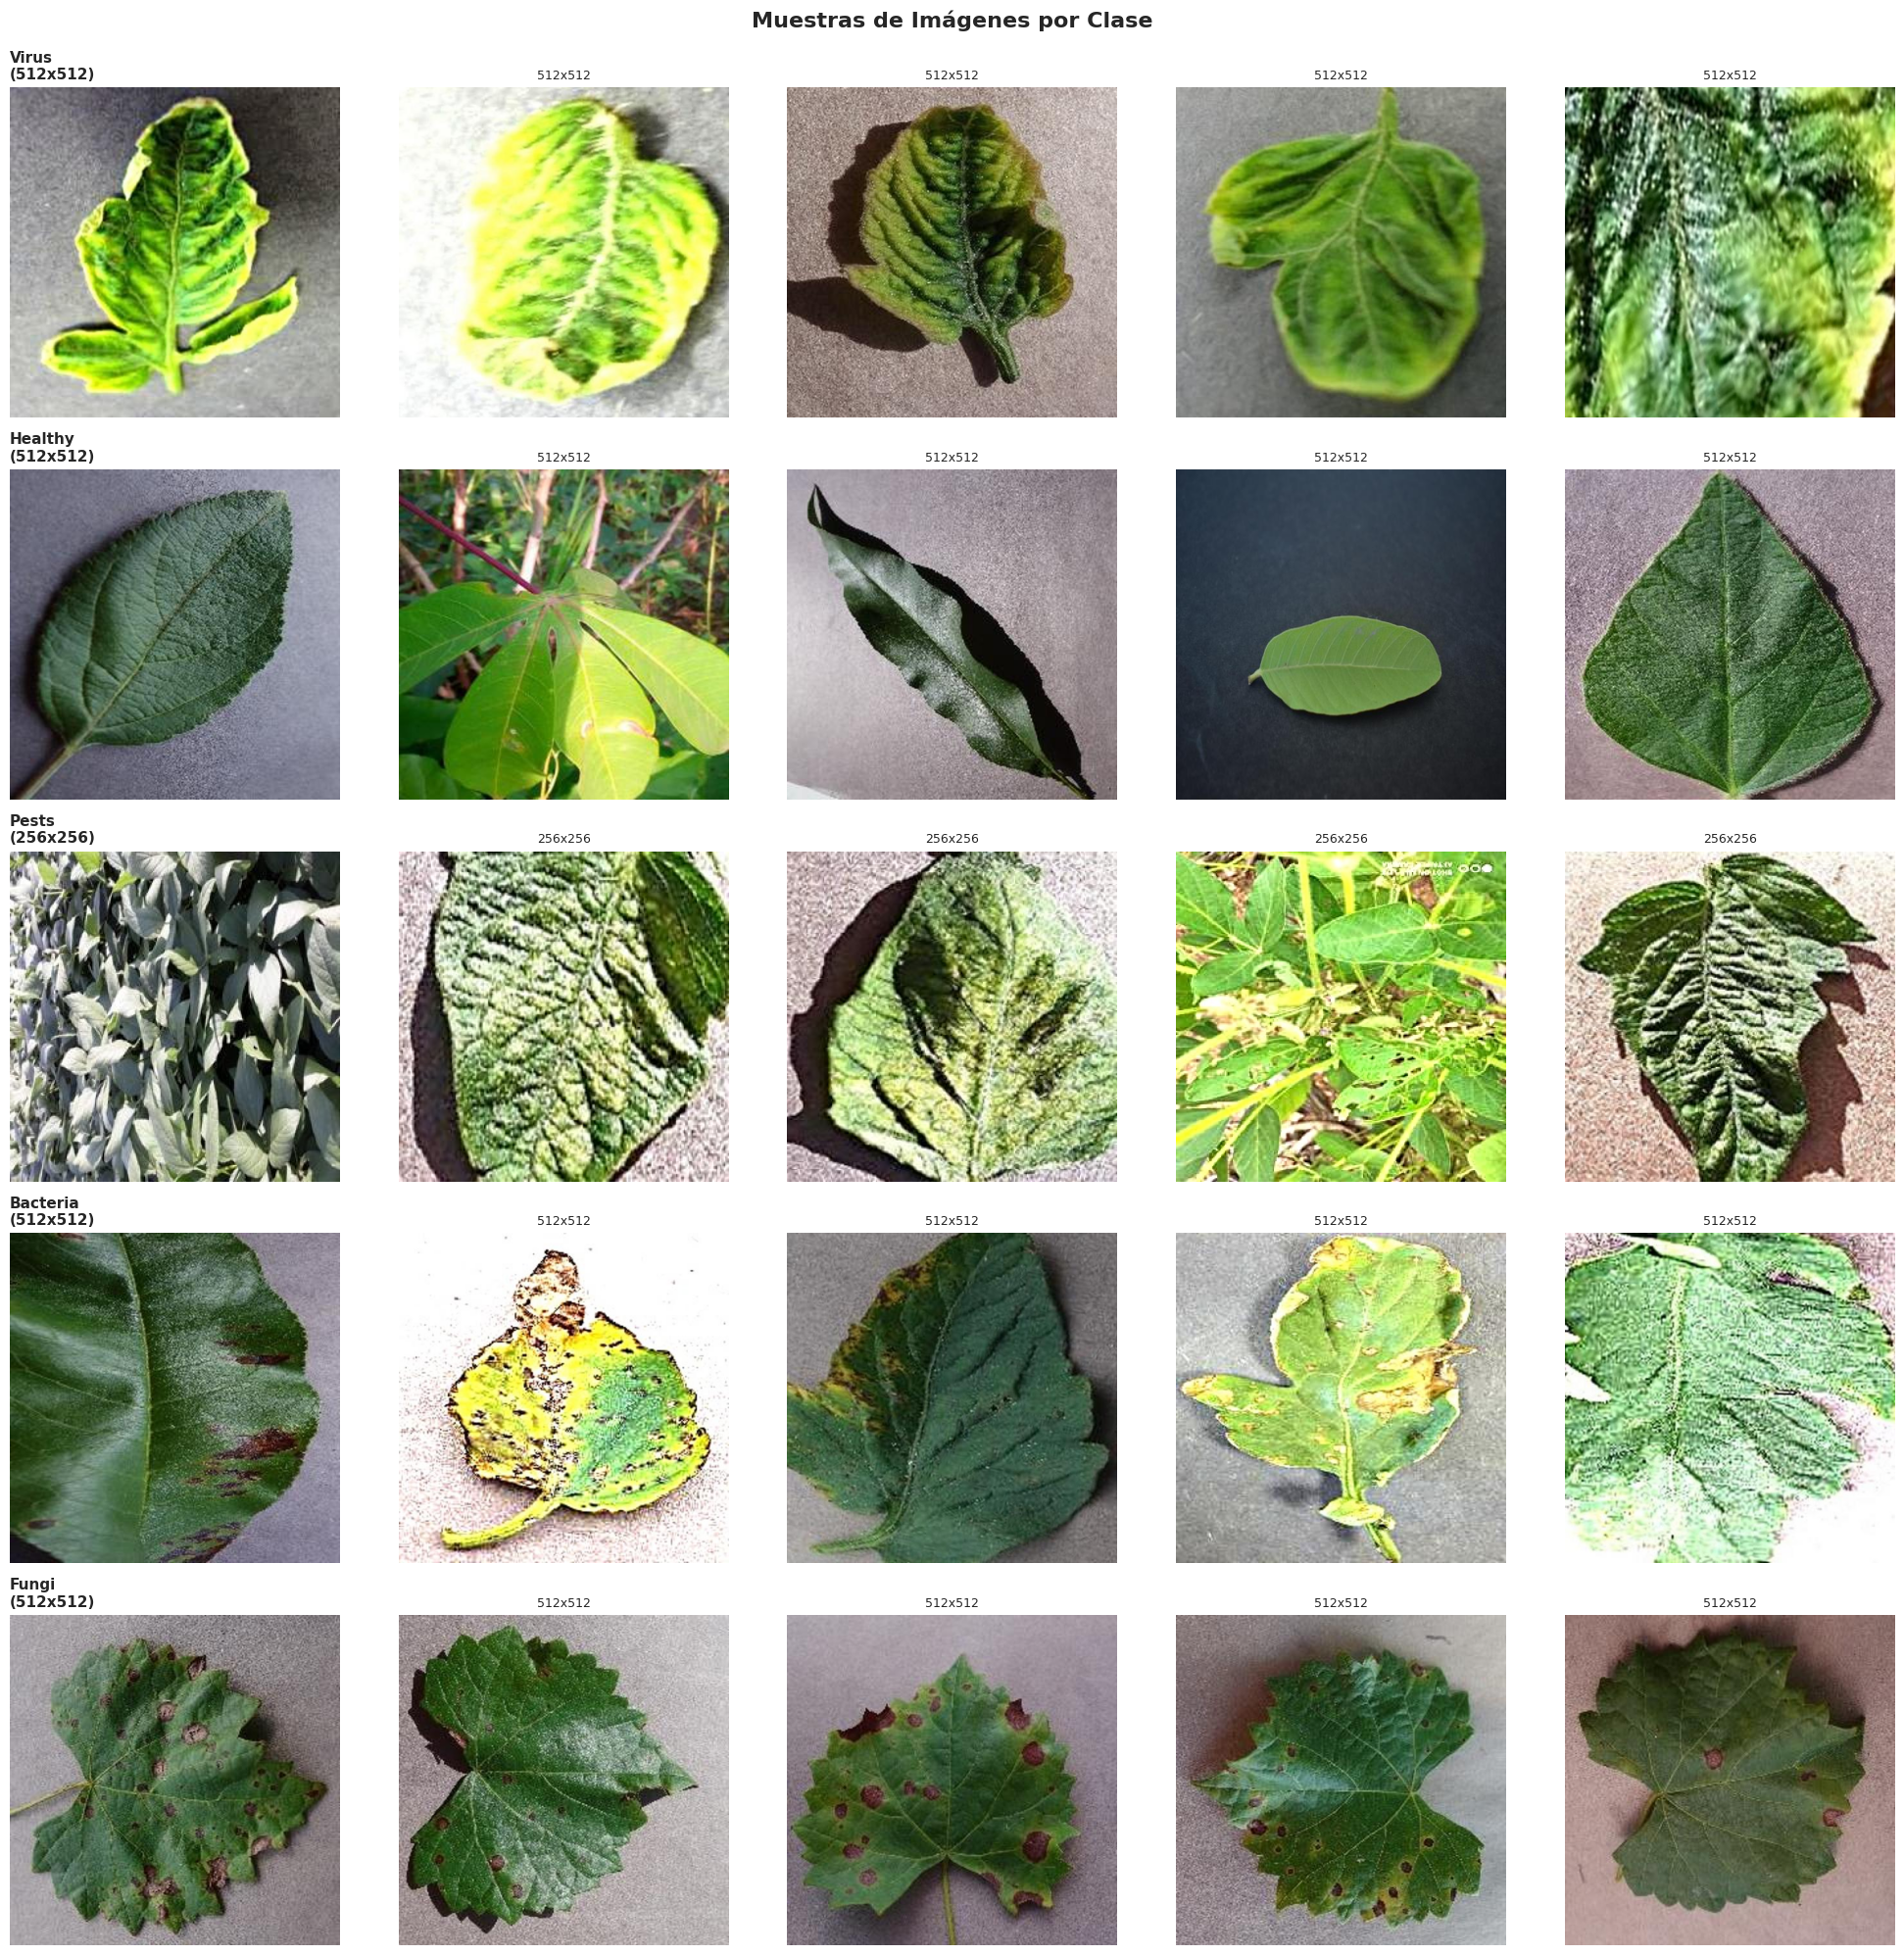

In [29]:
def mostrar_muestras_por_clase(directorio, muestras_por_clase=4):
    """
    Muestra imágenes de ejemplo de cada clase
    """
    clases = [d for d in os.listdir(directorio)
              if os.path.isdir(os.path.join(directorio, d))]

    n_clases = len(clases)
    fig, axes = plt.subplots(n_clases, muestras_por_clase,
                             figsize=(muestras_por_clase * 4, n_clases * 4))

    if n_clases == 1:
        axes = axes.reshape(1, -1)

    for i, clase in enumerate(clases):
        clase_path = os.path.join(directorio, clase)
        imagenes = [f for f in os.listdir(clase_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Seleccionar muestras aleatorias
        muestras = np.random.choice(imagenes,
                                    min(muestras_por_clase, len(imagenes)),
                                    replace=False)

        for j, img_name in enumerate(muestras):
            img_path = os.path.join(clase_path, img_name)
            img = plt.imread(img_path)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_title(f'{clase}\n({img.shape[0]}x{img.shape[1]})',
                                    fontsize=11, fontweight='bold', loc='left')
            else:
                axes[i, j].set_title(f'{img.shape[0]}x{img.shape[1]}',
                                    fontsize=9)

    plt.suptitle('Muestras de Imágenes por Clase',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

print("Mostrando muestras de cada clase...")
mostrar_muestras_por_clase(data_dir, muestras_por_clase=5)